<!-- DON'T EDIT THIS CELL! -->
<!-- TYPE SHIFT+ENTER AND GO TO THE NEXT CELL -->

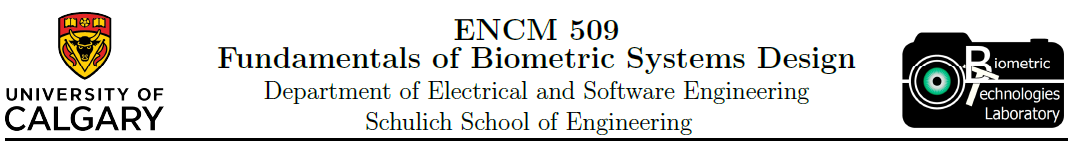

<center>
    <h1>Laboratory Experiment #6</h1>
    <h2>Face Recognition: Feature Extraction and Classification</h2>
</center>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage import exposure
import scipy.linalg as la

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

from utils_cm import plot_confusion_matrix

import matplotlib as mpl
# setting the default colormap for images only
mpl.rc('image', cmap='gray')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

## Exercises

**General Marks**
1. Introduction (a paragraph about the purpose of the lab).
1. Description of the result on each exercise  with illustrations/graphs and analysis of the results (marks are distributed as shown in the Exercise section). (10 marks)
1. Conclusion (a paragraph on what is the main take-out of the lab).

## Introduction

**In this lab we will be focusing on facial recognition which is made up of 2 main steps: feature extraction and classification. The main purpose of this lab is to investigate the Principal Component Analysis (PCA) approach for feature extraction, and Euclidean Distance and KNN for classification. We will be using the AT&T Faces Dataset downloaded from D2L, which contains 400 images of 40 subjects, each with 10 images. We will start by using Euclidean Distance as a similarity measure for classification, and from this data we will formulate 2 thresholds to classify the data into Known Face, Unknown face and Not a face. Then we will be investigating the effects of changing the number of Principal Components on the accuracy of the classification, before finally investigating with the effects of changing the number of neighbors for the KNN classifier.**

- **Exercise 1** (3 marks): For this exercise, you are going to build a gallery and perform the classification (matching) for the three cases (face known to the gallery, face unknown to the gallery and not-a-face). You need to choose two or three different subjects (for example, subjects 2, 3 and 4) from the dataset, or create your own dataset. Use the first 9 images of each subject to build the gallery dataset. For example, if you choose 3 subjects, then you have a gallery of 3 x 9 = 27 faces, and for algorithm each image is a sample, or input (no separate model is built per subject).

    Now, choose the probe images as follows:
    1. The 10th image of each of the three subjects in the dataset.
    2. 2-3 faces of the subjects not known to the dataset (could be yours, if you wish).
    3. 1-2 not-a-face image.

    For each of the comparisons, save the Euclidean distances calculated and annotate the minimum and maximum value in each case.

## Exercise 1

**In exercise 1, we are creating a gallery of 27 images from 3 subjects (9 from each subject). We are then normalizing these images to have a mean and standard deviation of 100 and 80 respectively. After the normaliation, we find the mean face of the gallery. We use the mean face to extract the different eigenfaces. After that, we begin probing the system with different input images and look then analyze the Euclidean distance. The types of probes we use are: An image that is not a human face, some images that are known to the system, and finally, some images that are not known to the system.**

## Reading and displaying the gallery of 27 images from 3 different subjects

Size of each image: (112, 92) 10304


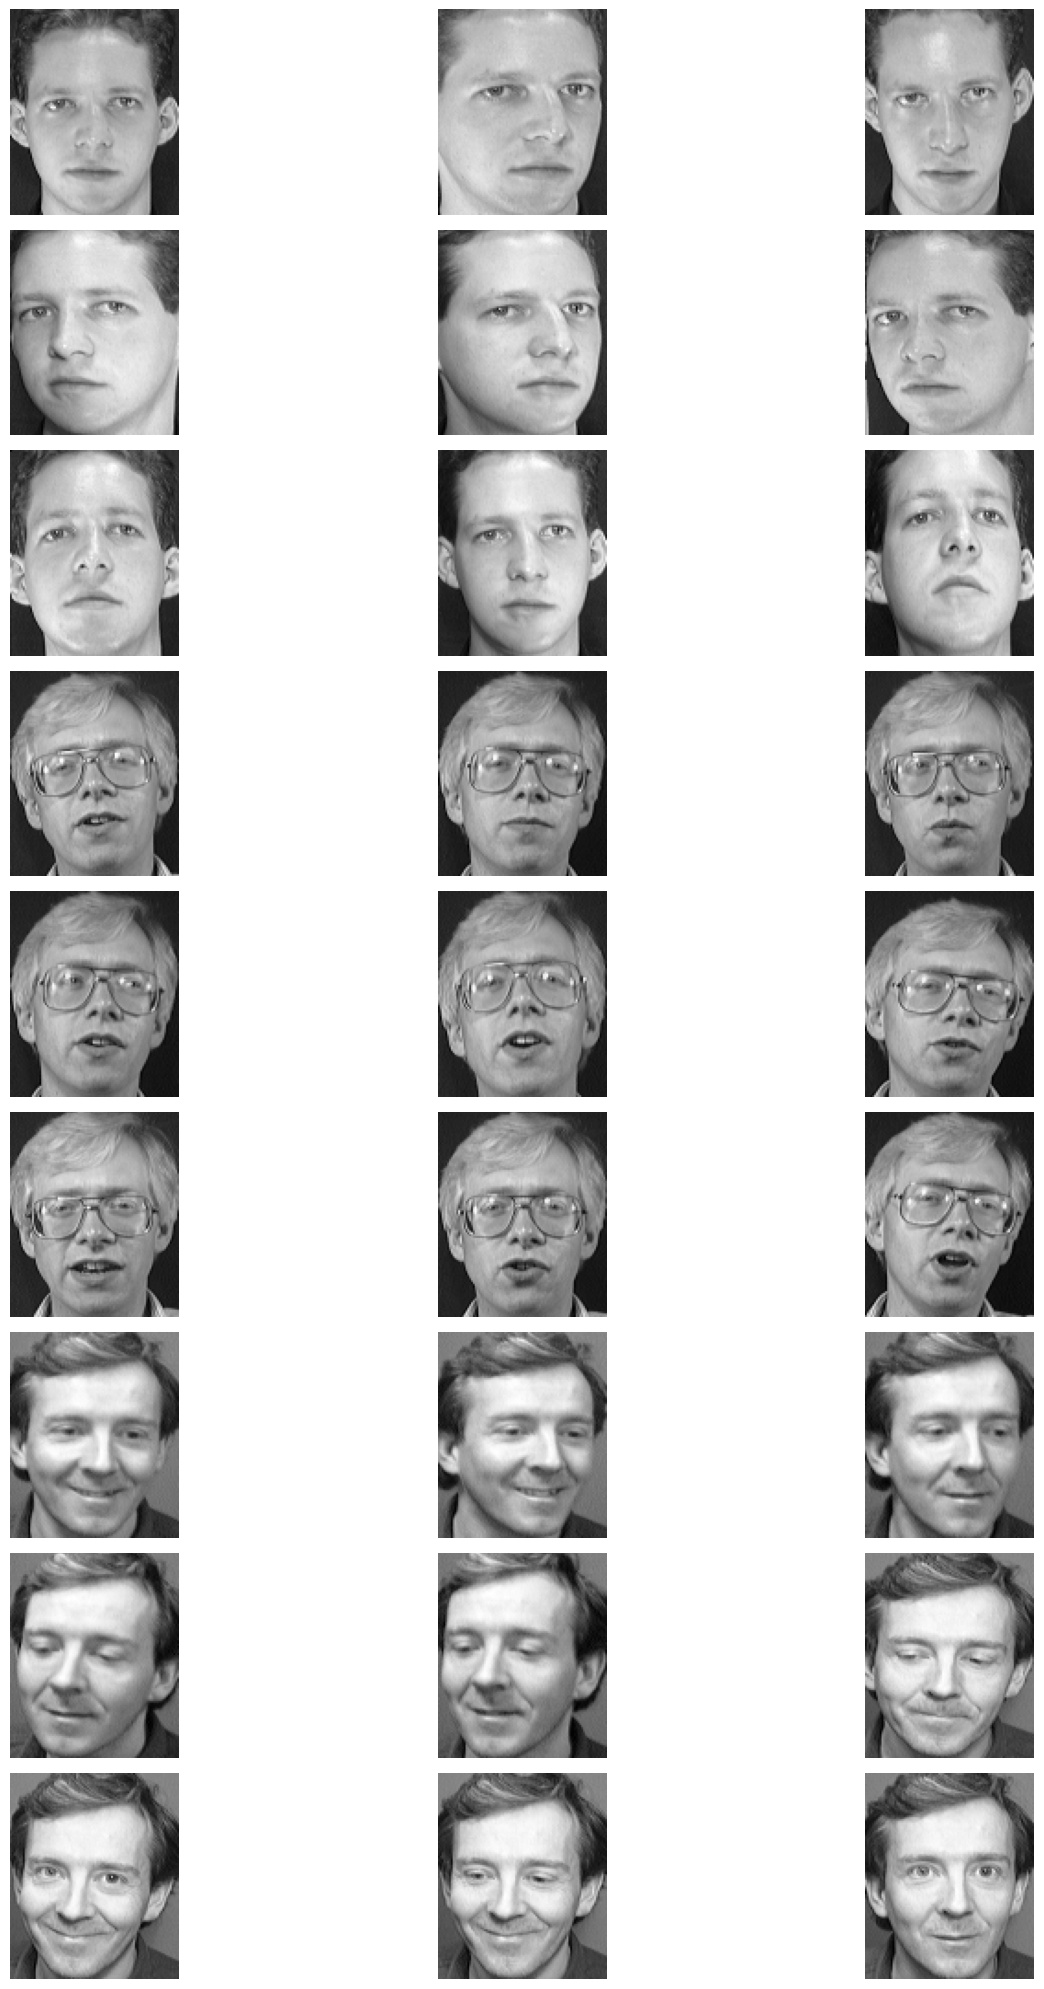

In [2]:
# You can specify your directories here, please, change the strings below:
paths = ['./ATT dataset/s1/', './ATT dataset/s2/', './ATT dataset/s3/']

# M is now 27 because we are loading 9 images from each of the 3 directories
M = len(paths) * 9

# can be any number that is close to the std and mean of most of the images.
um = 100
ustd = 80

# loading only one image to get the dimensions
# you can use images .jpg and .ng as well
img = imread(paths[0] + '1.pgm', as_gray=True)

# get the number of rows (irow) and columns (icol). 
# these values must to be the same for all images
irow, icol = img.shape

# allocation of vector that will have all images
S = np.zeros((irow*icol, M)) # img matrix

plt.figure(figsize=(20,20))
image_index = 0
for path in paths:
    for i in range(1, 10):  # Load 9 images from each directory
        img = imread(path + '{}.pgm'.format(i), as_gray=True)
        
        plt.subplot(9, 3, image_index+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        
        # reshape(img',irow*icol,1); 
        # creates a (N1*N2)x1 vector
        temp = np.reshape(img, (irow*icol,1))
        S[:,image_index] = temp[:,0]
        image_index += 1
# after finishing the sequence, S is a N1*N2xM matrix 

print('Size of each image:', img.shape, np.multiply(img.shape[0], img.shape[1]))

## Normalizing the gallery of 27 images

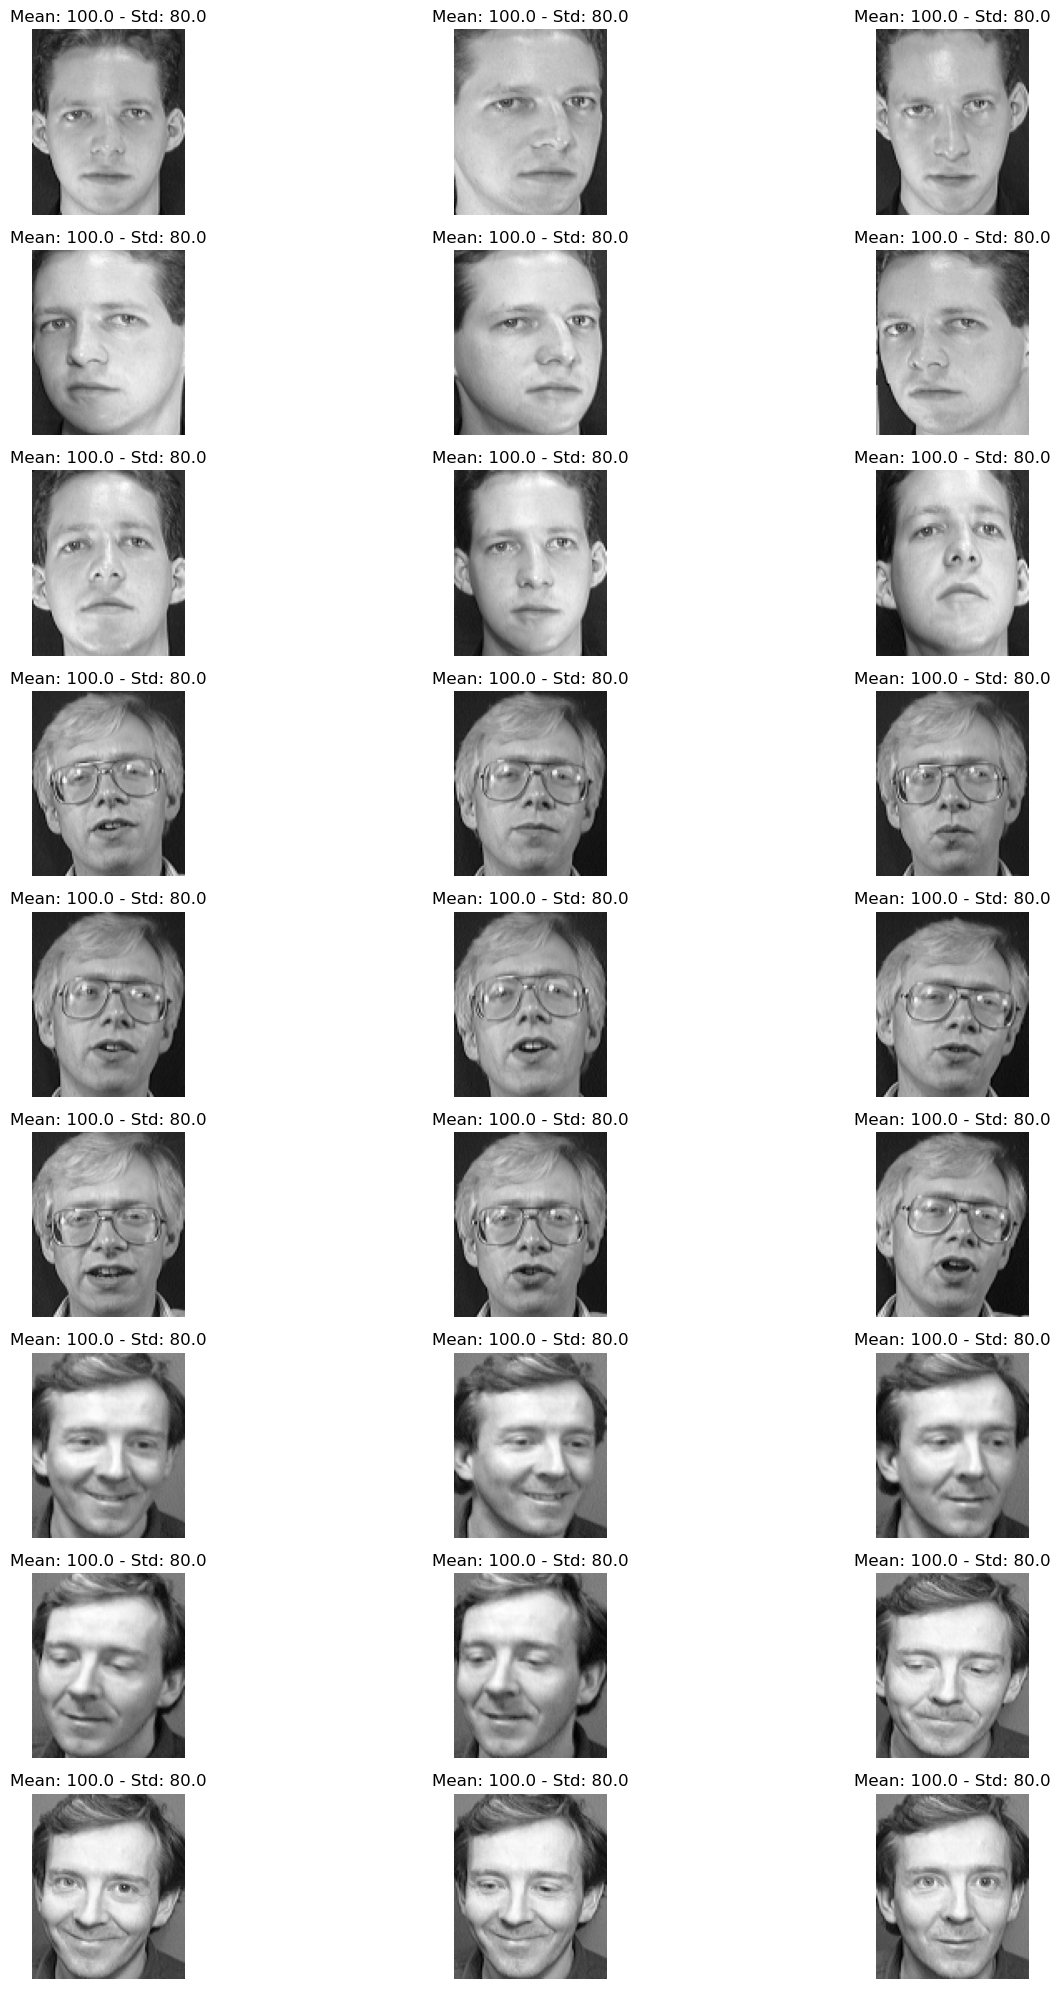

In [3]:
# looping over all the loaded images in S to normalize
for i in range(S.shape[1]):
    temp = S[:,i]
    m = np.mean(temp)
    st = np.std(temp)
    # calculation where are defined the new pixels intensities
    S[:,i] = (temp - m) * ustd / st + um

plt.figure(figsize=(20,20))
for i in range(M):
    img = np.reshape(S[:,i], (irow, icol))
    
    plt.subplot(9, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title('Mean: %.1f - Std: %.1f' % (np.mean(img), np.std(img)))

## Finding the mean image

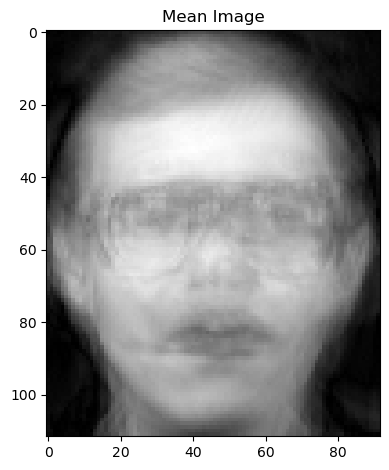

In [4]:
# calculates the mean of each row instead of each column
m = np.mean(S, axis=1)
# converts to unsigned 8-bit integer. Values range from 0 to 255
m = np.uint8(np.abs(m)).reshape(-1,1) 

img = np.reshape(m, (irow, icol))
plt.imshow(img, cmap='gray')
plt.title('Mean Image');

## Eigenvectors 

In [6]:
dbx = S.copy()
A = dbx.T
L = np.matmul(A, A.T)

# vv is the eigenvector for L
# dd is the eigenvalue for  L = dbx.T*dbx
dd, vv = la.eig(L)

v = np.zeros(vv.shape)
d = np.zeros(dd.shape)

for i in range(vv.shape[1]):
    if (dd[i] > 1e-4):
        v[:,i] = vv[:,i]
        d[i] = dd[i]
        
# sort d in ascending order
index = np.argsort(d)
B = d[index]
ind = np.zeros(index.shape).astype(int)
dtemp = np.zeros(index.shape)
vtemp = np.zeros(v.shape)

idx_len = len(index)
for i in range(idx_len):
    dtemp[i] = B[idx_len-1-i]
    ind[i] = idx_len-1-index[i]
    vtemp[:,ind[i]] = v[:,i]

d = dtemp
v = vtemp

for i in range(v.shape[1]):
    kk = v[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    v[:,i] = v[:,i] / temp
    
# Eigenvectors of C matrix
u = np.zeros(dbx.shape)
for i in range(v.shape[1]):
    temp = np.sqrt(d[i])
    u[:,i] = np.matmul(dbx, v[:,i]) / temp
    
for i in range(u.shape[1]):
    kk = u[:,i]
    temp = np.sqrt(np.sum(np.power(kk,2)))
    u[:,i] = u[:,i] / temp

C:\Users\alime\AppData\Local\Temp\ipykernel_27032\3992287868.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i] = dd[i]


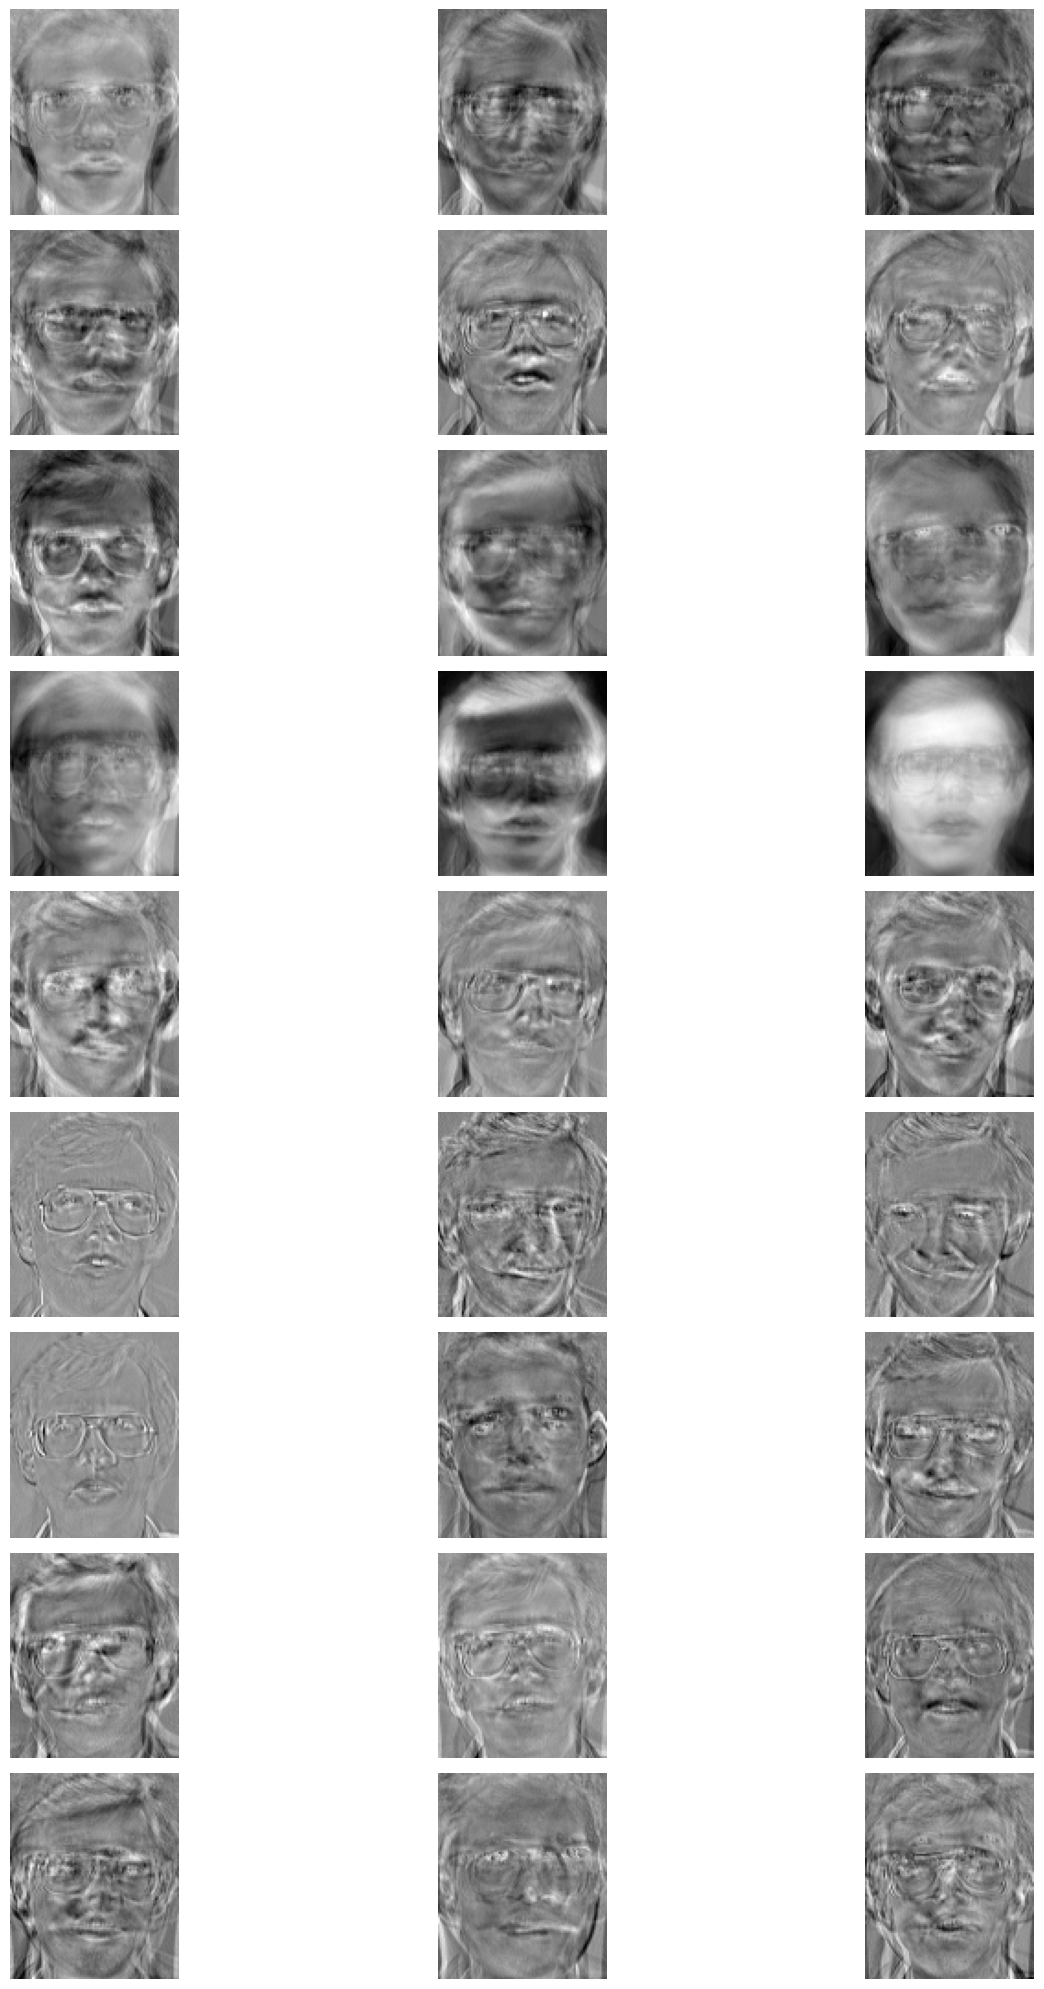

In [7]:
plt.figure(figsize=(20,20))
for i in range(M):
    img = np.reshape(u[:,i], (irow, icol))
    
    plt.subplot(9,3,i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

In [8]:
omega = np.zeros((M,M))
WW = np.zeros((M,1))

for h in range(dbx.shape[1]):
    for i in range(u.shape[1]):
        t = u[:,i].T
        WeightOfImage = np.dot(t, dbx[:,h].T)
        WW[i] = WeightOfImage
    omega[:,h] = WW[:,0]

## Comparing the mean image to an image that is not a face

In [9]:
path = './'
InputImage = imread(path + 'CalgaryTower.jpg', as_gray=True)

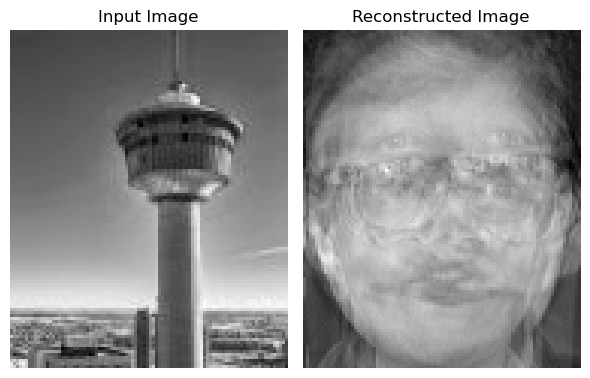

In [10]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.imshow(InputImage, cmap='gray')
plt.title('Input Image')
plt.axis('off')

InImage = np.reshape(InputImage, (irow*icol,1))

# Normalization
temp = InImage
me = np.mean(temp)
st = np.std(temp)
temp = (temp-me) * ustd/st + um
NormImage = temp

# Finding Difference: NormalizedImage - MeanImage
Difference = temp - m

p = np.zeros((u.shape[1],1))
for i in range(u.shape[1]):
    # dot returns scalar vector product
    pare = np.dot(u[:,i], NormImage) 
    p[i] = pare

# m is the mean image, u is the eigenvector
ReshapedImage = m + np.matmul(u, p) 
ReshapedImage = np.reshape(ReshapedImage, (irow,icol))

# show the reconstructed image
plt.subplot(1,2,2)
plt.imshow(ReshapedImage, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

InImWeight = np.zeros((M,1))

for i in range(u.shape[1]):
    t = u[:,i].reshape(-1,1).T
    # scalar vector product of vectors t and Difference
    WeightOfInputImage = np.dot(t, Difference) 
    InImWeight[i] = WeightOfInputImage


## Finding Euclidean distance betweeen the Calgary tower image and all the images in the gallery

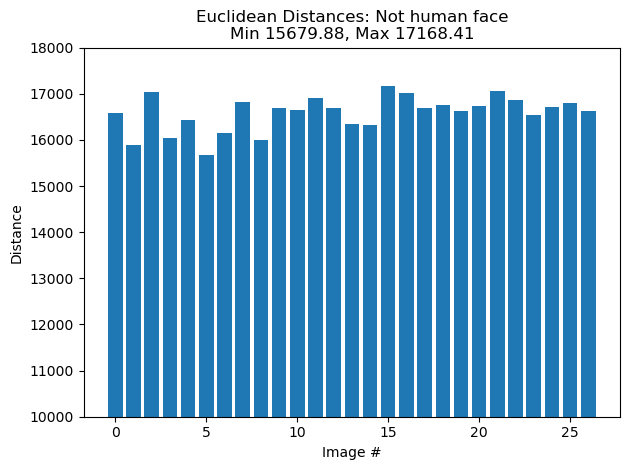

In [11]:
# find the euclidean distance between the input image and all the images in the database
eTower = np.zeros((M,1))
for i in range(omega.shape[1]):
    q = omega[:,i].reshape(-1,1)
    DiffWeight = InImWeight - q
    mag = np.linalg.norm(DiffWeight)
    eTower[i] = mag

# max/min Eucledian distance
MaximumValue = np.max(eTower)
MinimumValue = np.min(eTower)

plt.bar(np.arange(len(eTower)), eTower.flatten())
plt.ylim([10000, 18000])
plt.xlabel('Image #')
plt.ylabel('Distance')
plt.title('Euclidean Distances: Not human face\n'\
        'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue));


## Probe images that are known to the system

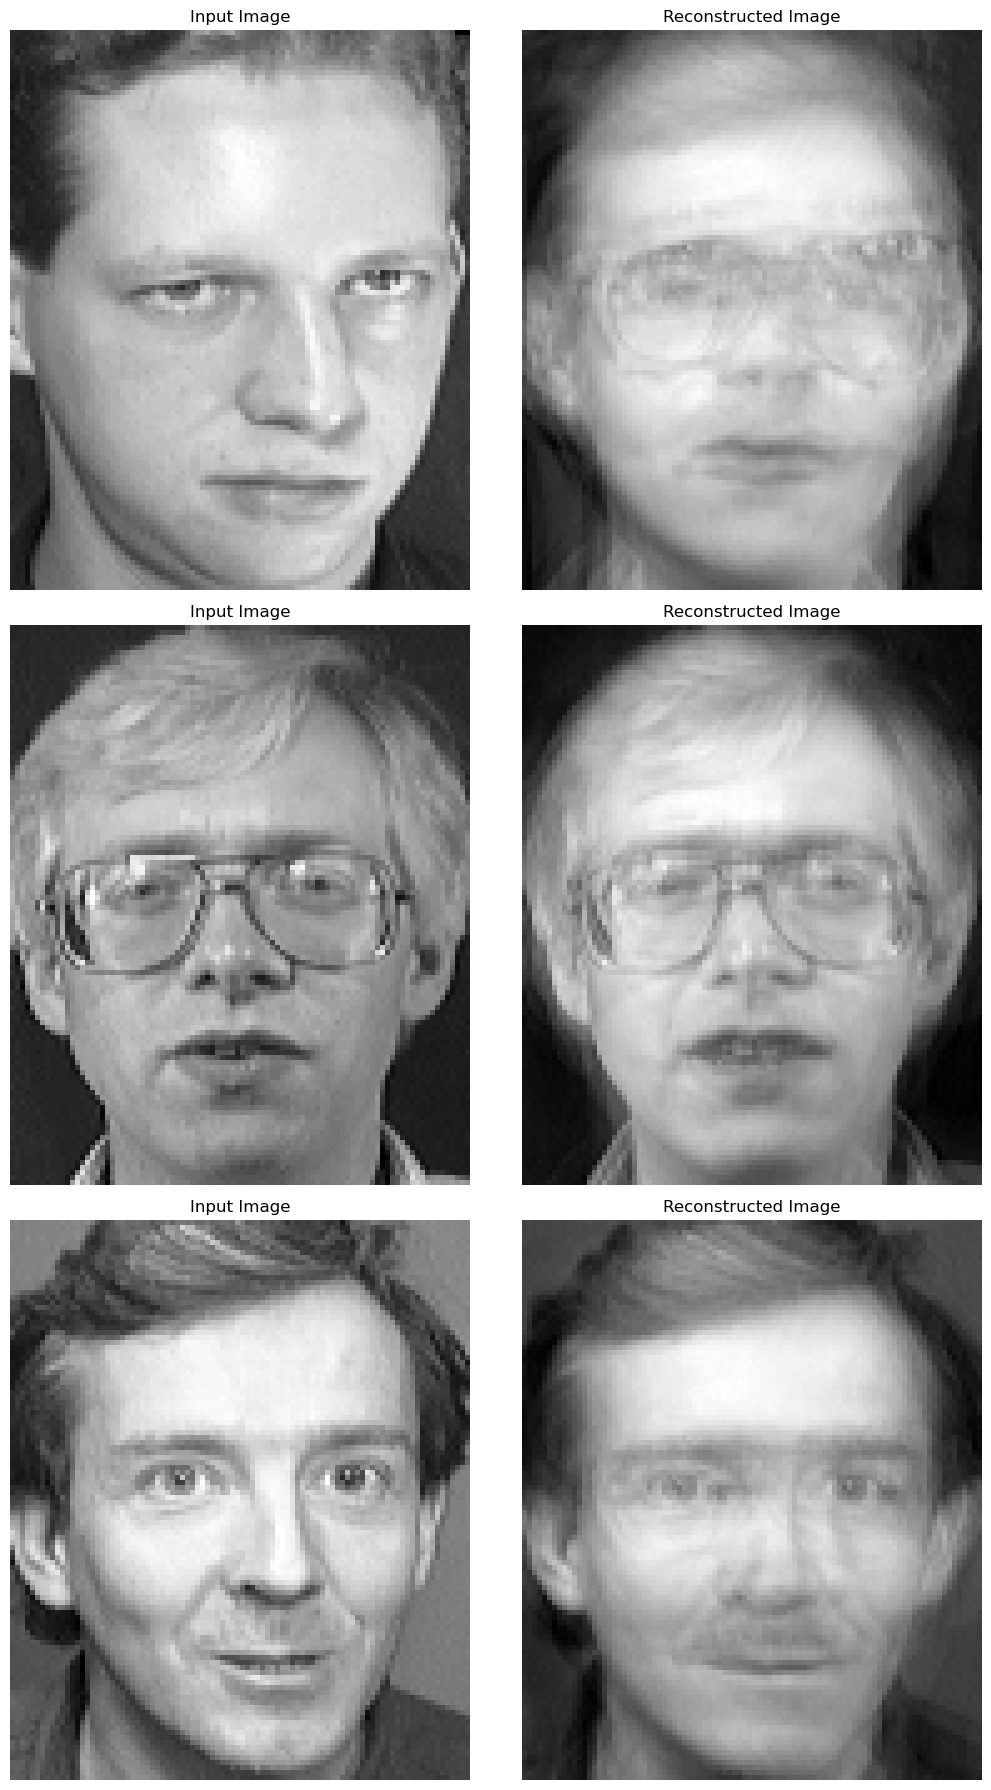

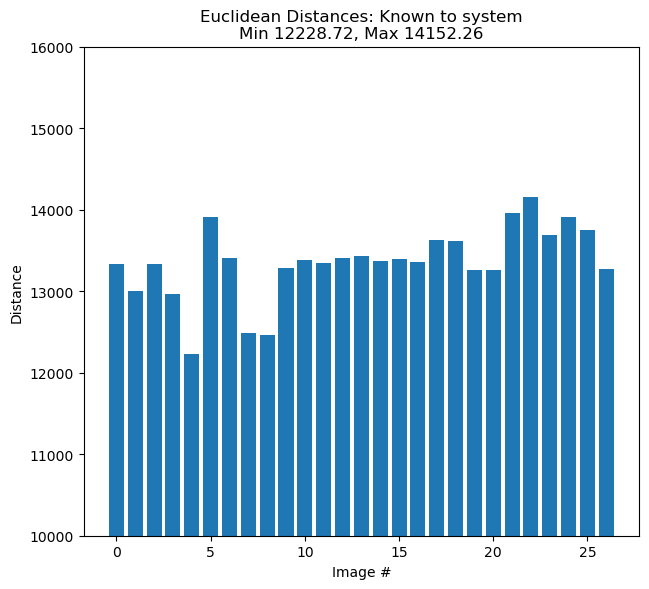

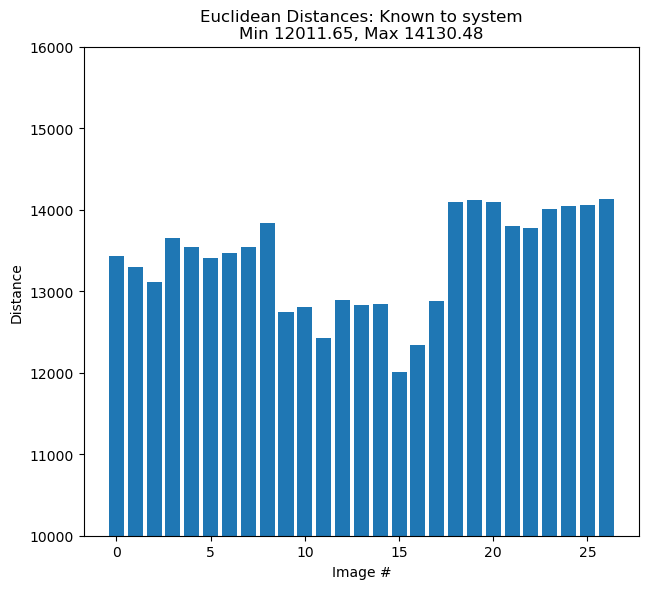

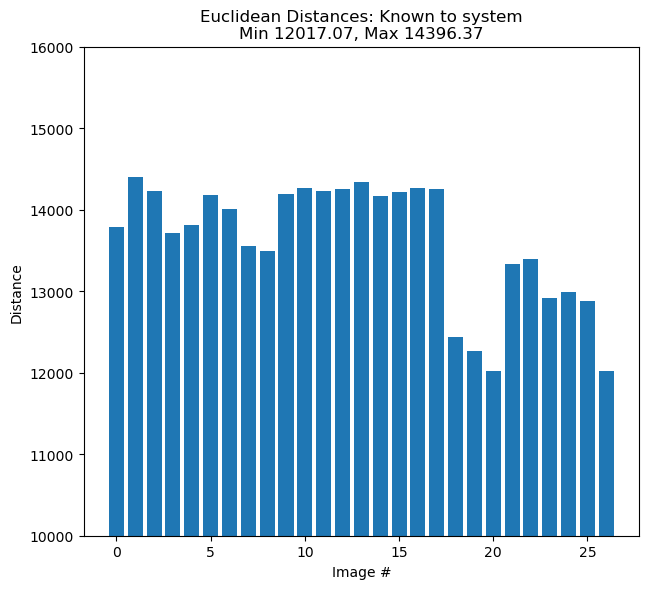

In [13]:
paths = ['./ATT dataset/s1/', './ATT dataset/s2/', './ATT dataset/s3/']

fig, axs = plt.subplots(3, 2, figsize=(12, 18))

probe_images = ['10.pgm']

eKnown = [np.zeros((M,1)), np.zeros((M,1)), np.zeros((M,1))]

for j, path in enumerate(paths):
    for i, image in enumerate(probe_images):
        InputImage = imread(path + image, as_gray=True)
        axs[j, 0].imshow(InputImage, cmap='gray')
        axs[j, 0].set_title('Input Image')
        axs[j, 0].axis('off')

        InImage = np.reshape(InputImage, (irow*icol,1))
        temp = (InImage - np.mean(InImage)) * ustd/np.std(InImage) + um
        Difference = temp - m

        p = np.dot(u.T, temp)
        ReshapedImage = np.reshape(m + np.matmul(u, p), (irow,icol))

        axs[j, 1].imshow(ReshapedImage, cmap='gray')
        axs[j, 1].set_title('Reconstructed Image')
        axs[j, 1].axis('off')

        InImWeight = np.dot(u.T, Difference)
        eKnown[j] = np.linalg.norm(InImWeight - omega, axis=0)

        MaximumValue = np.max(eKnown[j]) 
        MinimumValue = np.min(eKnown[j]) 

        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, i+1)
        plt.bar(np.arange(len(eKnown[j])), eKnown[j].flatten())
        plt.ylim([10000, 16000])
        plt.xlabel('Image #')
        plt.ylabel('Distance')
        plt.title('Euclidean Distances: Known to system\n'\
                'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue))

## Probe images that are not known to the system

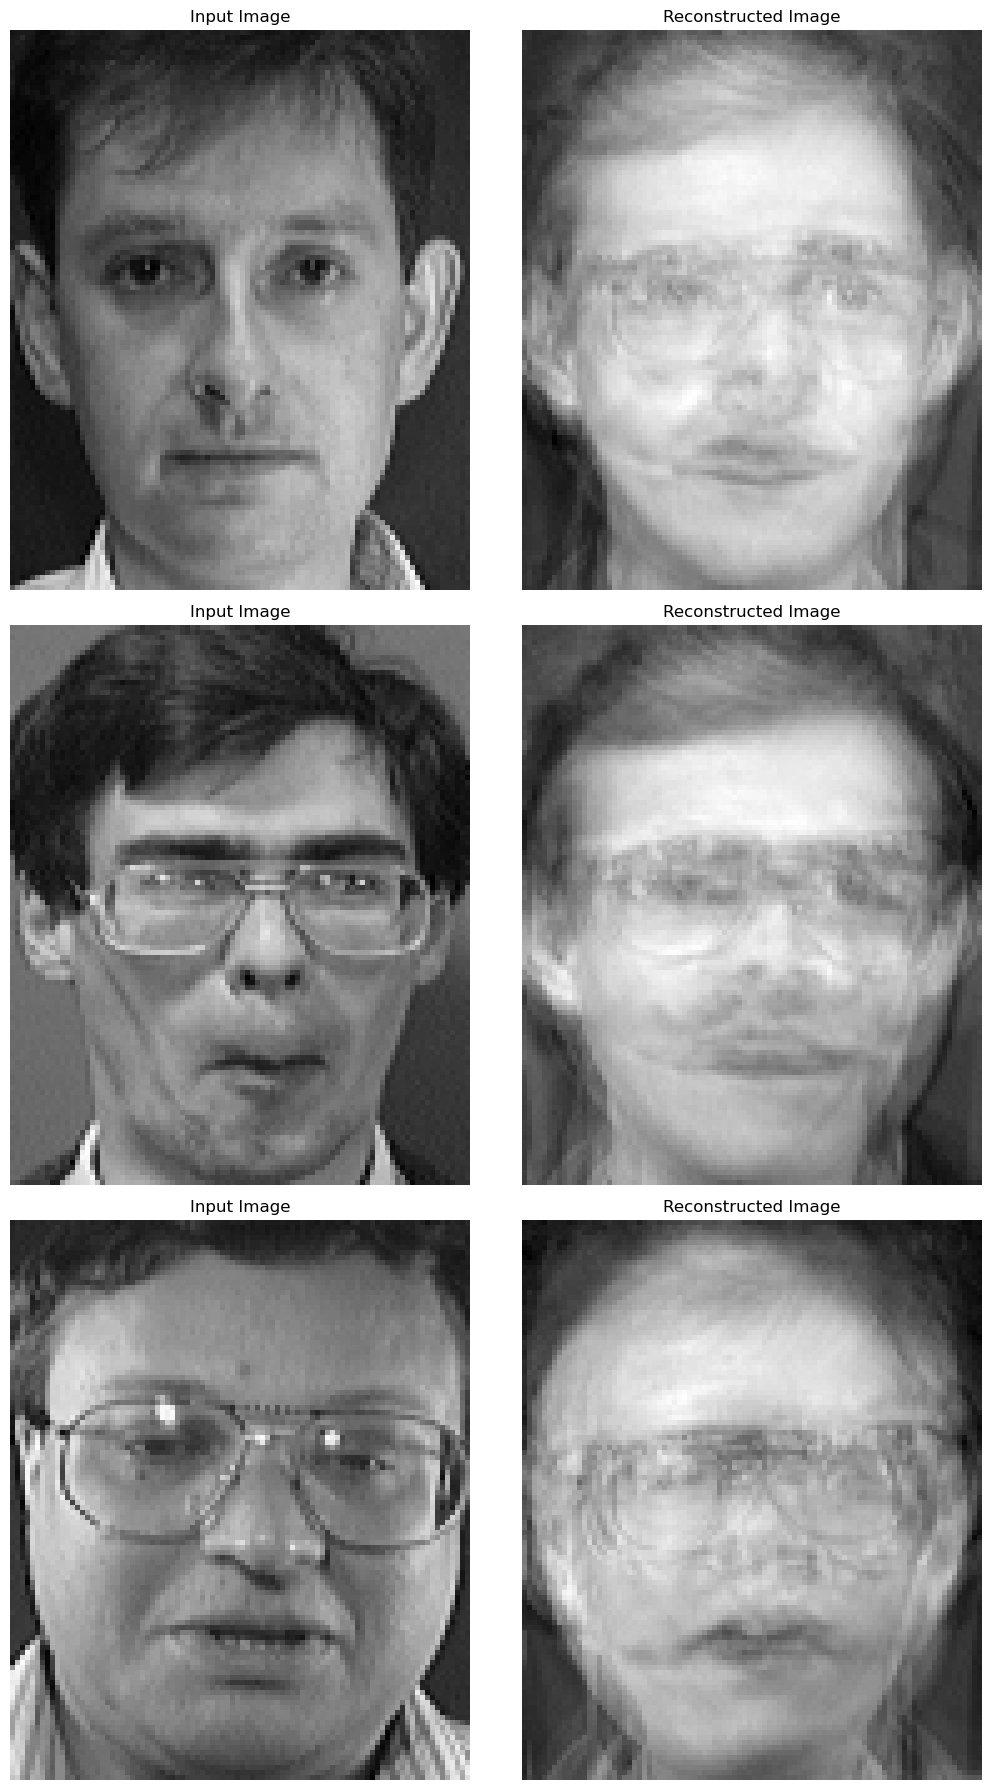

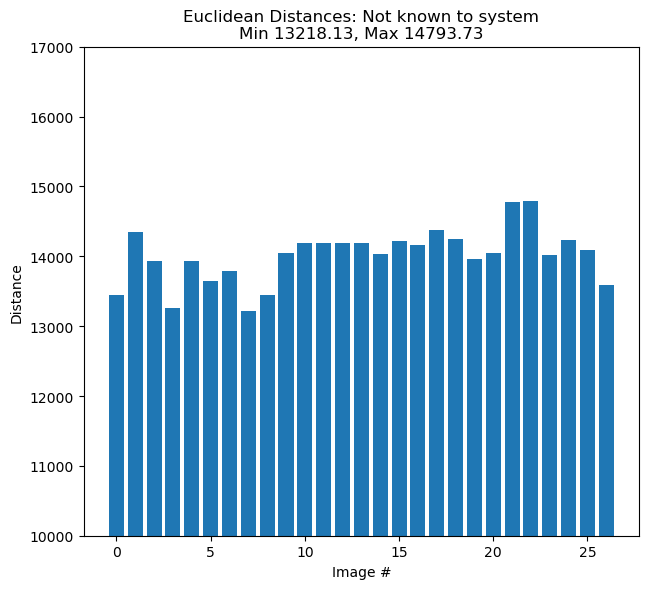

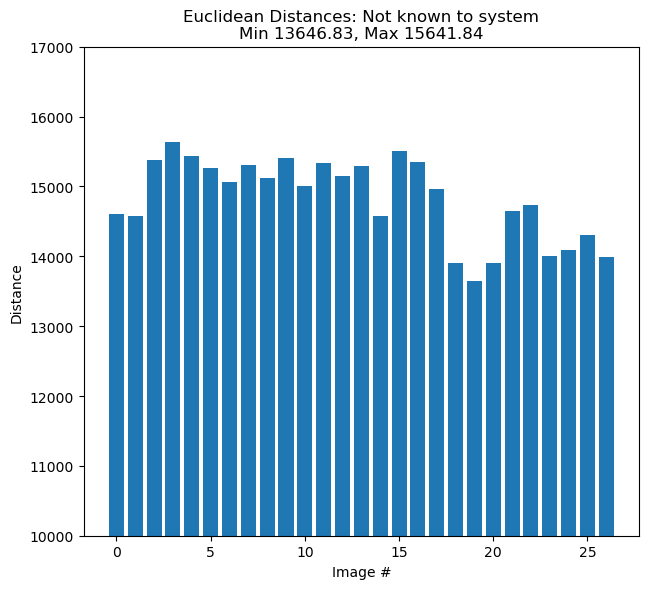

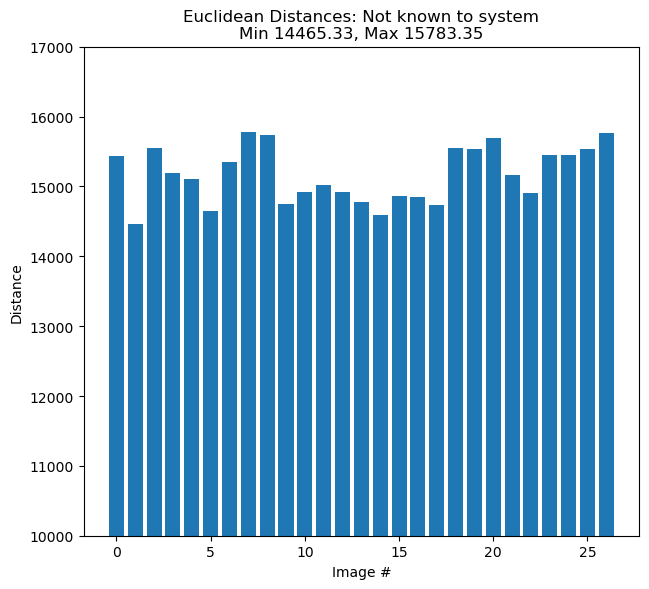

In [14]:
paths = ['./ATT dataset/s24/', './ATT dataset/s20/', './ATT dataset/s31/']

fig, axs = plt.subplots(3, 2, figsize=(12, 18))

probe_images = ['10.pgm']

eNotKnown = [np.zeros((M,1)), np.zeros((M,1)), np.zeros((M,1))]

for j, path in enumerate(paths):
    for i, image in enumerate(probe_images):
        InputImage = imread(path + image, as_gray=True)
        axs[j, 0].imshow(InputImage, cmap='gray')
        axs[j, 0].set_title('Input Image')
        axs[j, 0].axis('off')

        InImage = np.reshape(InputImage, (irow*icol,1))
        temp = (InImage - np.mean(InImage)) * ustd/np.std(InImage) + um
        Difference = temp - m

        p = np.dot(u.T, temp)
        ReshapedImage = np.reshape(m + np.matmul(u, p), (irow,icol))

        axs[j, 1].imshow(ReshapedImage, cmap='gray')
        axs[j, 1].set_title('Reconstructed Image')
        axs[j, 1].axis('off')

        InImWeight = np.dot(u.T, Difference)
        eNotKnown[j] = np.linalg.norm(InImWeight - omega, axis=0)

        MaximumValue = np.max(eNotKnown[j]) 
        MinimumValue = np.min(eNotKnown[j]) 

        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, i+1)
        plt.bar(np.arange(len(eNotKnown[j])), eNotKnown[j].flatten())
        plt.ylim([10000, 17000])
        plt.xlabel('Image #')
        plt.ylabel('Distance')
        plt.title('Euclidean Distances: Not known to system\n'\
                'Min {:.2f}, Max {:.2f}'.format(MinimumValue, MaximumValue))

## Results summary

### Images that are not a face:

#### Minimums:

- 15679.88
#### Maximums:

- 17168.41

### Images that are known to the system:

#### Minimums:
- 12228.72
- 12011.65
- 12017.07

#### Maximums:
- 14152.26
- 14130.48
- 14396.37

### Images not known to the system:

#### Minimums:
- 13218.13
- 13646.83
- 14465.33

#### Maximums:
- 14793.73
- 15461.84
- 15783.35


- **Exercise 2** (3 marks):Determine the first and the second thresholds; hint: analyze the maximum of the Euclidean distances for the probe images known to the dataset. To find the second threshold, use unknown faces as the input faces and gather all the Euclidean distance. Hint: consider the maximum as the second threshold, but also analyze other values.

    Extend the Lab’s Jupyter notebook, so that it can calculate the thresholds as investigated above in Exercise 2, and provide the decision output: ‘Face is known to the dataset, subject 2’, ‘Face is unknown to the dataset’, or ‘Not-a-face’. Draw conclusions and make suggestions on the procedure improvement.

## Exercise 2

**In exercise 2, we will be analyzing the results obtained in exercise 1 and extending the given classifying functionality to be able to dynamically create a threshold. We will invesitage the minimums, maximums, and means of all the different probe images and come up with a selection algorithm for the first and second thresholds. We will then analyze the effectiveness of our selected thresholds and observe whether or not they resulted in a correct classification.**

## Selecting thresholds

**After inspecting the results summary from exercise 1, we can make some conclusions. First, we can see that there is a clear difference between the distances of each of the categories with little overlap. For example the minimums for all the images known to the system lie around 12000 while the minimums for the images not known to the system lie around 13000 and the minimum for the image that is not a human face is almost 15700. Because the minimum of the non human image is significantly higher than the others, we can easily identify non human images using this system. We can set a threshold of 16000 for our second threshold. We need to be more careful with our first threshold as there is some overlap**

In [54]:
print("The mean distance for the non human image is: ", np.mean(eTower))
print("The mean distance for the known image 1 is: ", np.mean(eKnown[0]))
print("The mean distance for the known image 2 is: ", np.mean(eKnown[1]))
print("The mean distance for the known image 3 is: ", np.mean(eKnown[2]))
print("The mean distance for the unknown image 1 is: ", np.mean(eNotKnown[0]))
print("The mean distance for the unknown image 2 is: ", np.mean(eNotKnown[1]))
print("The mean distance for the unknown image 3 is: ", np.mean(eNotKnown[2]))

distances = [eTower, eKnown[0], eKnown[1], eKnown[2], eNotKnown[0], eNotKnown[1], eNotKnown[2]]

print("\n")

threshold1 = np.mean(eKnown) + np.std(eKnown)/2
threshold2 = np.mean(eTower) - np.std(eTower)/2

print("Threshold 1: ", threshold1)
print("Threshold 2: ", threshold2)

print("\n")

#check whether an image is known to the system or not and if it is a face or not
for i, distance in enumerate(distances):
    if (np.mean(distance) <= threshold1):
        print('Image %d is in the database' % (i+1))
    elif (np.mean(distance) > threshold1 and np.mean(distance) <= threshold2):
        print('Image %d is a face but not in the database' % (i+1))
    elif (np.mean(distance) > threshold2):
        print('Image %d is not a face' % (i+1))




The mean distance for the non human image is:  16587.482823774997
The mean distance for the known image 1 is:  13355.736809176458
The mean distance for the known image 2 is:  13377.21696600167
The mean distance for the known image 3 is:  13615.830643548075
The mean distance for the unknown image 1 is:  14014.364527495058
The mean distance for the unknown image 2 is:  14822.547149891721
The mean distance for the unknown image 3 is:  15176.388006342526


Threshold 1:  13759.357437249455
Threshold 2:  16403.602501542176


Image 1 is not a face
Image 2 is in the database
Image 3 is in the database
Image 4 is in the database
Image 5 is a face but not in the database
Image 6 is a face but not in the database
Image 7 is a face but not in the database


**Based on the results above, we have succeeded in selecting thresholds. We were able to classify all images correctly. For our threshold selection, we averaged out the mean euclidean distances of all the probes known to the system, we then proceeded to add half the standard deviation to be able to capture the ones that have a higher than average score for an authentic image. We did not add an enitre standard deviation as that could result in incorrectly classifying images that are not known to the system that have a lower than average euclidean distance. For the second threshold, we took a similar approach but decided to sibtract half a standard deviation instead to be able to catch images that are not known to the system with an irregularly high threshold. This threshold selection can be made more accurate by accumulating more data, but based on our results, we can already see that it is quite good at classifying the images.**

- **Exercise 3** (2 marks): In the description of the face recognition using PCA and KNN above, the PCA was used with 100 principal components. Now repeat the same procedure using 50 and 200 principal components. Evaluate the resulting classifier accuracy, using Confusion matrix. Visualize the comparison using either a table or a bar plot (comparing the results for the three number of components: 50, 100 (already done) and 200).


## Helper Function

In [159]:
def prediction_evaluation(predicted_label, true_label, subject_id=1):
    # accuracy can be calculated as: 
    # predictedRight / (predictedRight + predictedWrong)
    right, wrong = 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == realLabel:
            right += 1
        else:
            wrong += 1
    acc = right / (right + wrong) 
    print("Overall Accuracy: %d%%" % (acc * 100))
    
    # True Positive (TP): real label IS subject_id and predicted label IS subject_id
    # False Positive (FP): real label is NOT subject_id while predicted label IS subject_id
    # True Negative (TN): real label is NOT subject_id and predicted label is NOT subject_id
    # False Negative (FN): real label IS subject_id and predicted label is NOT subject_id
    
    TP, FP, TN, FN = 0, 0, 0, 0
    for predictedLabel, realLabel in zip(predicted_label, true_label):
        if predictedLabel == subject_id and realLabel == subject_id:
            TP += 1
        if predictedLabel != subject_id and realLabel == subject_id:
            FN += 1
        if predictedLabel != subject_id and realLabel != subject_id:
            TN += 1
        if predictedLabel == subject_id and realLabel != subject_id:
            FP += 1
    print("Subject #%d:\n\tTP: %d, FP: %d, TN: %d, FN: %d" % (subject_id, TP, FP, TN, FN))
    
    # True Positive Rate (TPR) also known as Sensitivity or Recall
    TPR = TP / (TP + FN)
    # True Negative Rate (TNR) also known as Specificity
    TNR = TN / (TN + FP)
    # False Positive Rate (FPR)
    FPR = FP / (FP + TN)
    # False Negative Rate (FNR)
    FNR = FN / (TP + FN)

    print("\tTPR: %.2f%%, TNR: %.2f%%, FPR: %.2f%%, FNR: %.2f%%" % (TPR*100, TNR*100, FPR*100, FNR*100))

## Reading Images

In [160]:
n_subjects = 40

n_training_images = 5
n_test_images = 5

knn_neighbors = 3

accuracies = []

# use the first 5 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 5 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

## 50 Principal Components

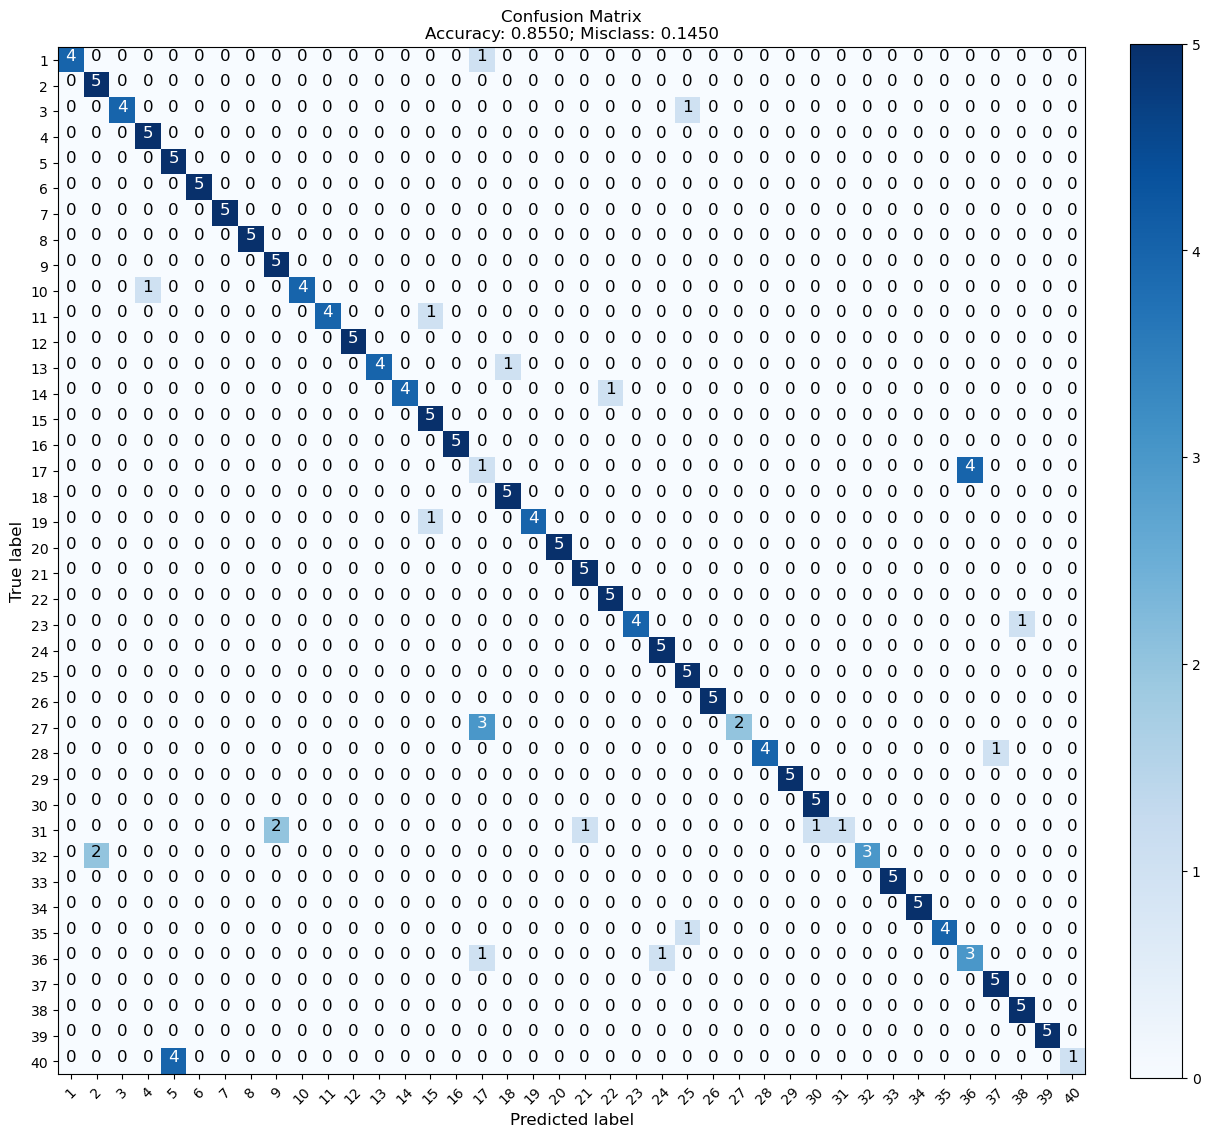

In [161]:
# n_components: number of principal components
n_components_pca = 50
pca = PCA(n_components=n_components_pca)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces)

train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
predictedLabels = knn_pca.predict(test_pca)
# for subjectId in range(1, n_subjects+1):
#     prediction_evaluation(predictedLabels, testingLabels, subjectId)

# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

accuracies.append( (np.trace(confusionMatrix) / float(np.sum(confusionMatrix))) * 100 )

plot_confusion_matrix(cm=confusionMatrix, target_names = [i for i in range(1, n_subjects+1)])

## 100 Principal Components

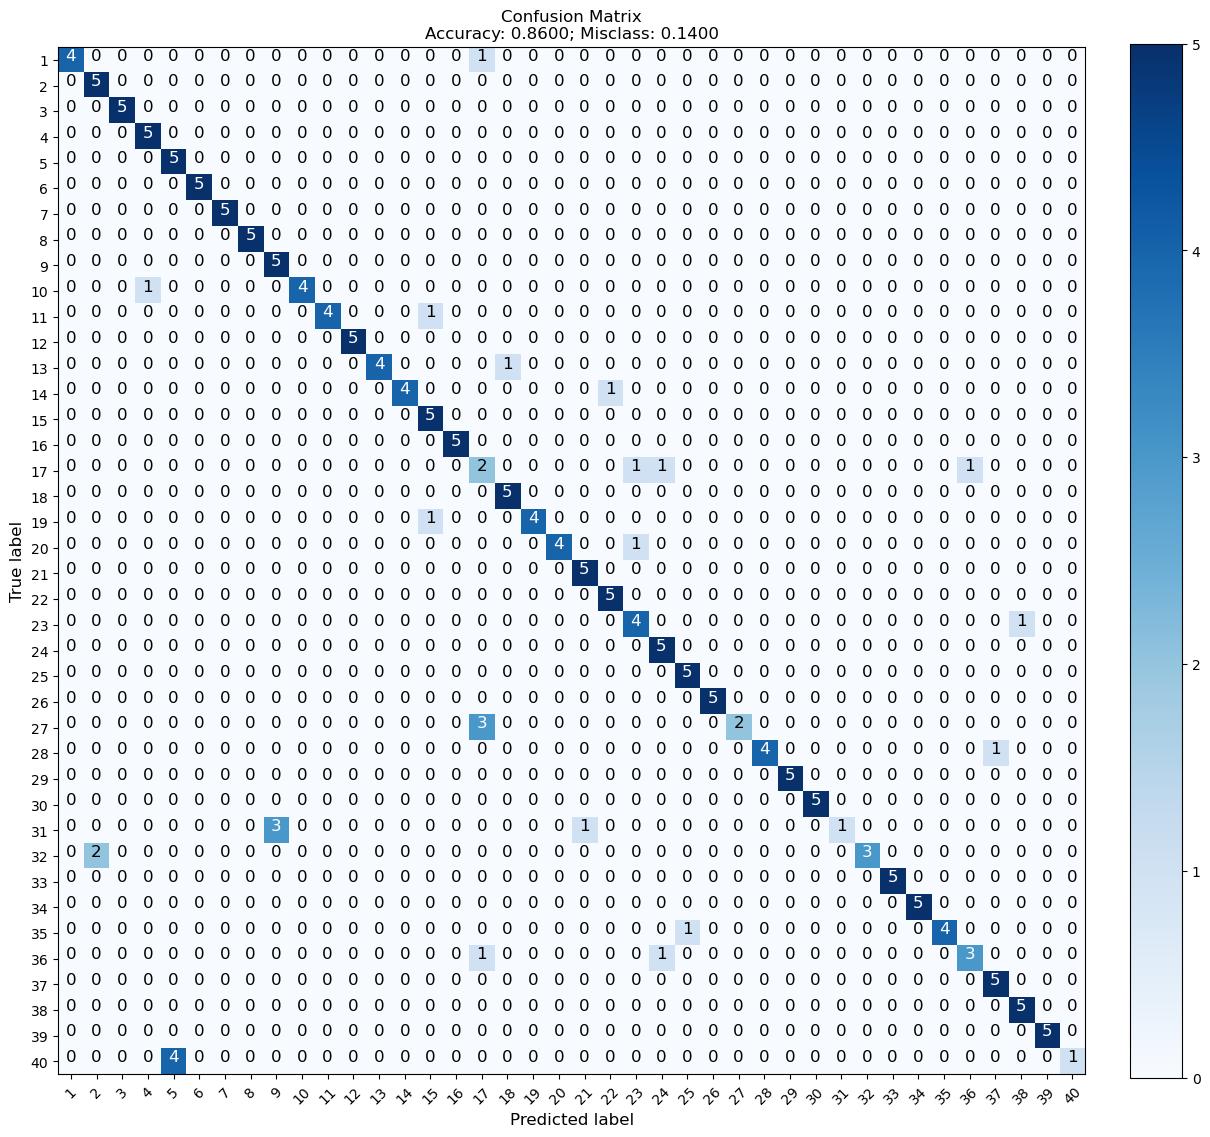

In [162]:
# n_components: number of principal components
n_components_pca = 100
pca = PCA(n_components=n_components_pca)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces)

train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
predictedLabels = knn_pca.predict(test_pca)
# for subjectId in range(1, n_subjects+1):
#     prediction_evaluation(predictedLabels, testingLabels, subjectId)

# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

accuracies.append( (np.trace(confusionMatrix) / float(np.sum(confusionMatrix))) * 100 )

plot_confusion_matrix(cm=confusionMatrix, target_names = [i for i in range(1, n_subjects+1)])

## 200 Principal Components

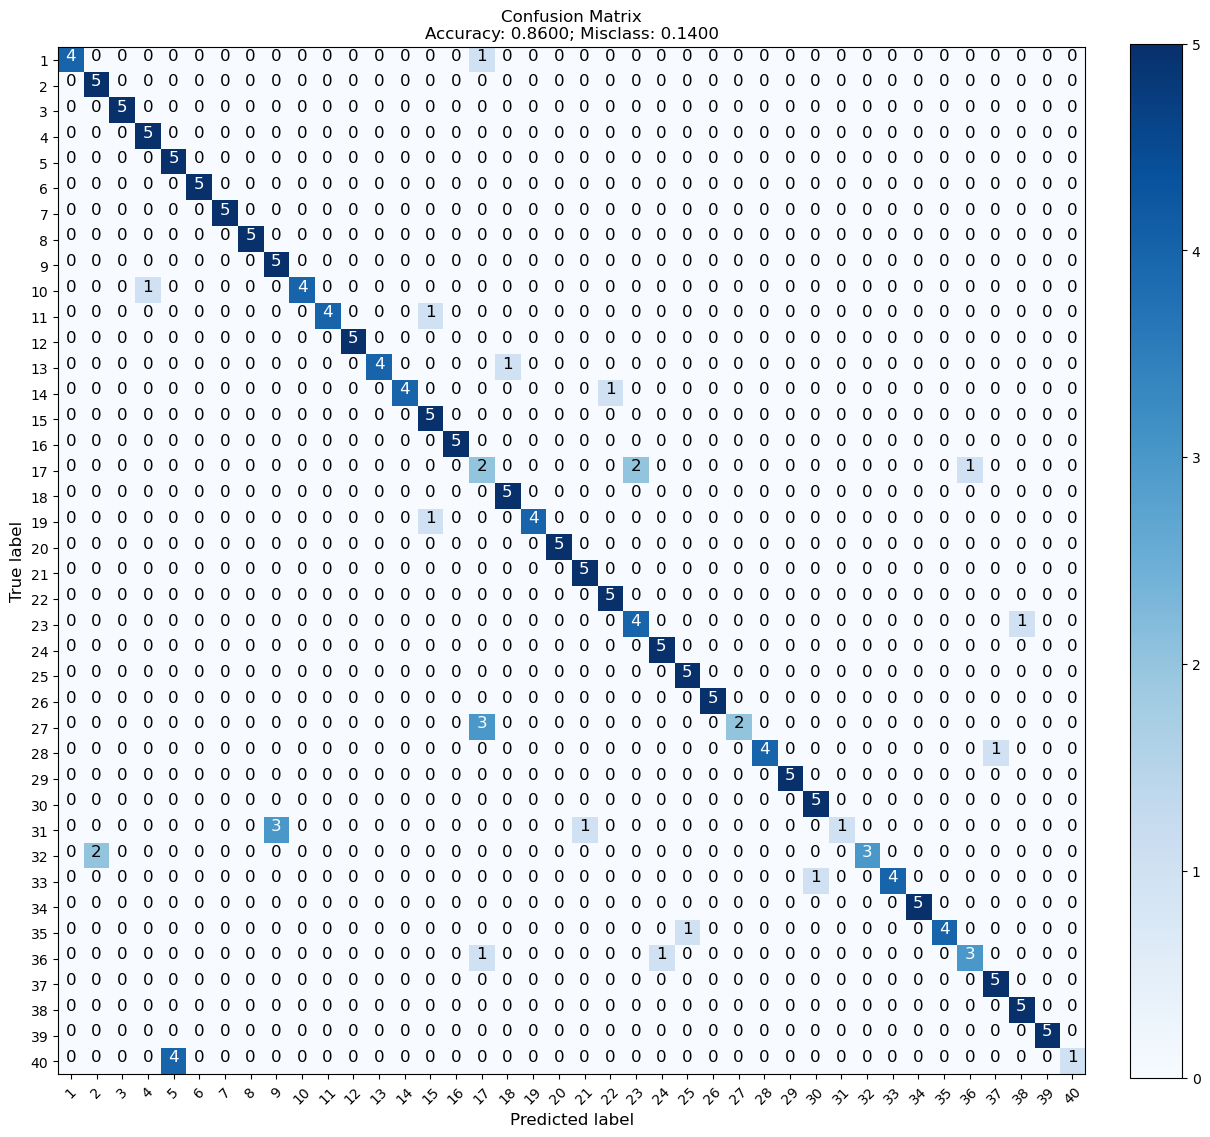

In [163]:
# n_components: number of principal components
n_components_pca = 200
pca = PCA(n_components=n_components_pca)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces)

train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
predictedLabels = knn_pca.predict(test_pca)
# for subjectId in range(1, n_subjects+1):
#     prediction_evaluation(predictedLabels, testingLabels, subjectId)

# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

accuracies.append( (np.trace(confusionMatrix) / float(np.sum(confusionMatrix))) * 100 )

plot_confusion_matrix(cm=confusionMatrix, target_names = [i for i in range(1, n_subjects+1)])

## Comparison Bar Plots

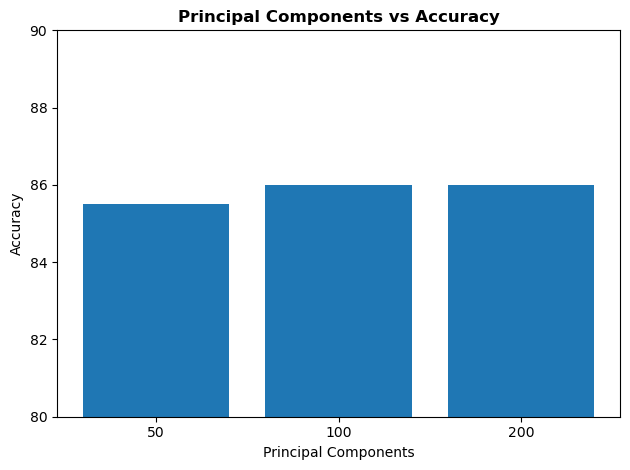

In [164]:
PCA_list = ["50", "100", "200"]
plt.bar(PCA_list, accuracies)
plt.xlabel("Principal Components")
plt.ylabel("Accuracy")
plt.ylim([80, 90])
plt.title("Principal Components vs Accuracy", fontweight='bold')
plt.show()

## Analysis

**We can see that using a low number of principal components of 50, we get the lowest accuracy score of 85%. When we increase the number of principal components to 100, we get a 1% increase in accuracy up to 86%. However, a further increase to the number or principal components to 200, doesn't yeild any significant change to the accuracy and it remains at 86%. All in all, the difference between 50 Principal Components and 100/200 Principal Components results in a 1% increase in accuracy which isn't really a huge difference unless huge amounts of data are used.**

- **Exercise 4** (2 marks): Evaluate the impact of the number of neighbors (K) defined for the KNN. Using the same data separation (20 subjects, 8 images per subject are used for training and 2 for testing). Conduct the two experiments considering, for example: 1) 5 neighbors and 2) 11 neighbors. Compare the KNN classifier results, using the Confusion matrices, and draw the conclusions.

## Reading Images

In [165]:
n_subjects = 20

n_training_images = 8
n_test_images = 2

# use the first 5 images from subjectID 1-n_subjects to train the classifier
trainingFaces = []
trainingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(1, n_training_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        trainingFaces.append(np.reshape(img, (img.size,)))
        trainingLabels.append(subjectId)

# use the last 5 images from subjectID 1-20 to test the classifier
testingFaces = []
testingLabels = []
for subjectId in range(1, n_subjects+1):
    for imageId in range(n_training_images+1, n_training_images+n_test_images+1):
        img = imread("./ATT dataset/s%d/%d.pgm" %(subjectId, imageId), as_gray=True)
        testingFaces.append(np.reshape(img, (img.size,)))
        testingLabels.append(subjectId)

## 5 Neighbors

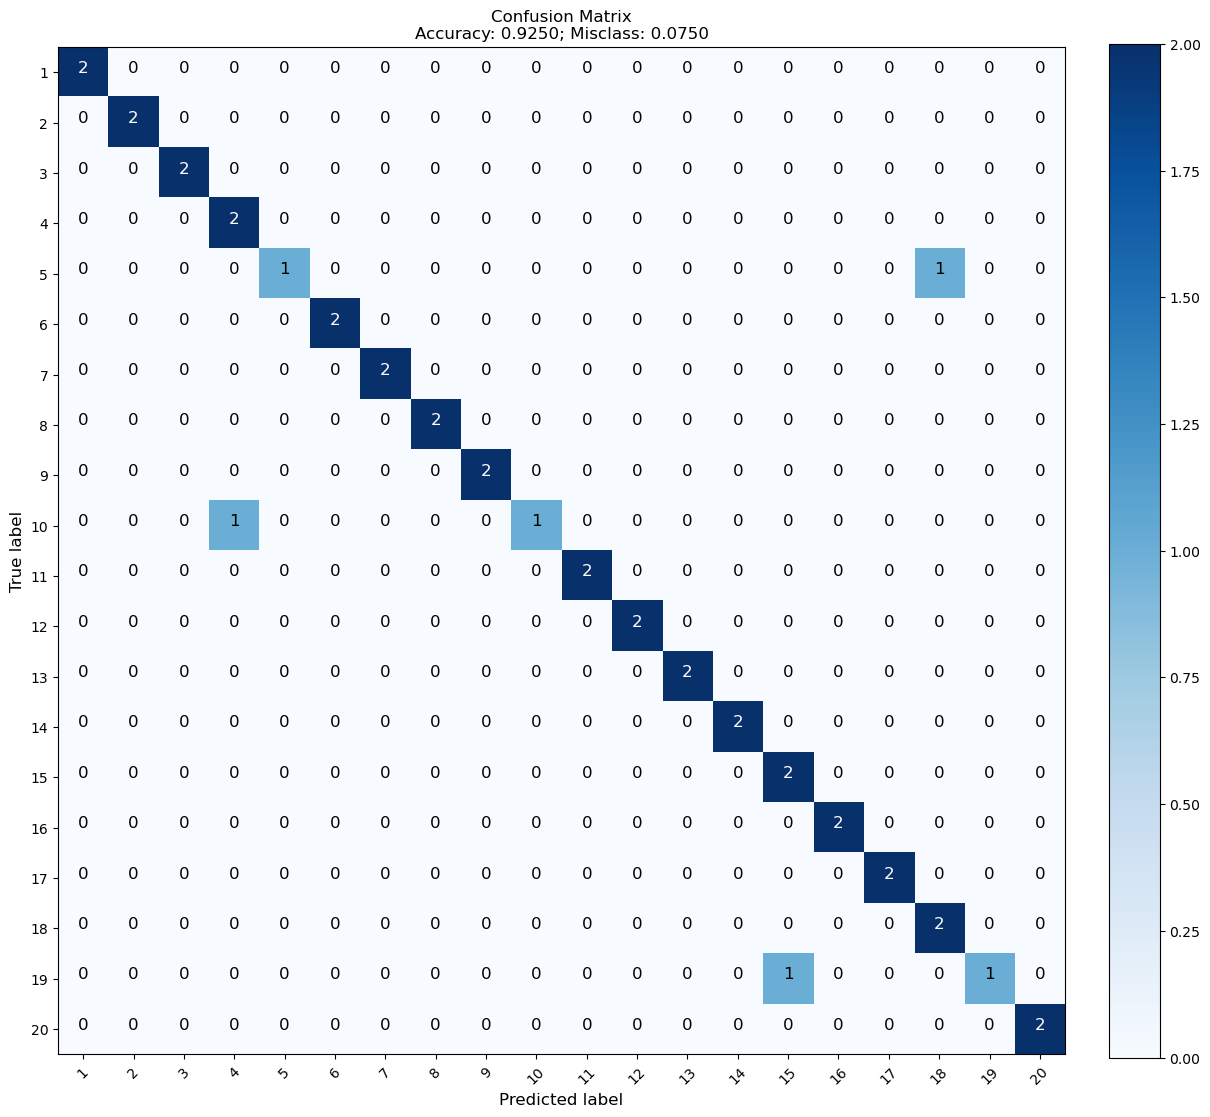

In [166]:
# Using 5 nearest neighbors
knn_neighbors = 5

# n_components: number of principal components
n_components_pca = 100
pca = PCA(n_components=n_components_pca)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces)

train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
predictedLabels = knn_pca.predict(test_pca)
# for subjectId in range(1, n_subjects+1):
#     prediction_evaluation(predictedLabels, testingLabels, subjectId)

# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

# accuracies.append( (np.trace(confusionMatrix) / float(np.sum(confusionMatrix))) * 100 )

plot_confusion_matrix(cm=confusionMatrix, target_names = [i for i in range(1, n_subjects+1)])

## 11 Neighbors

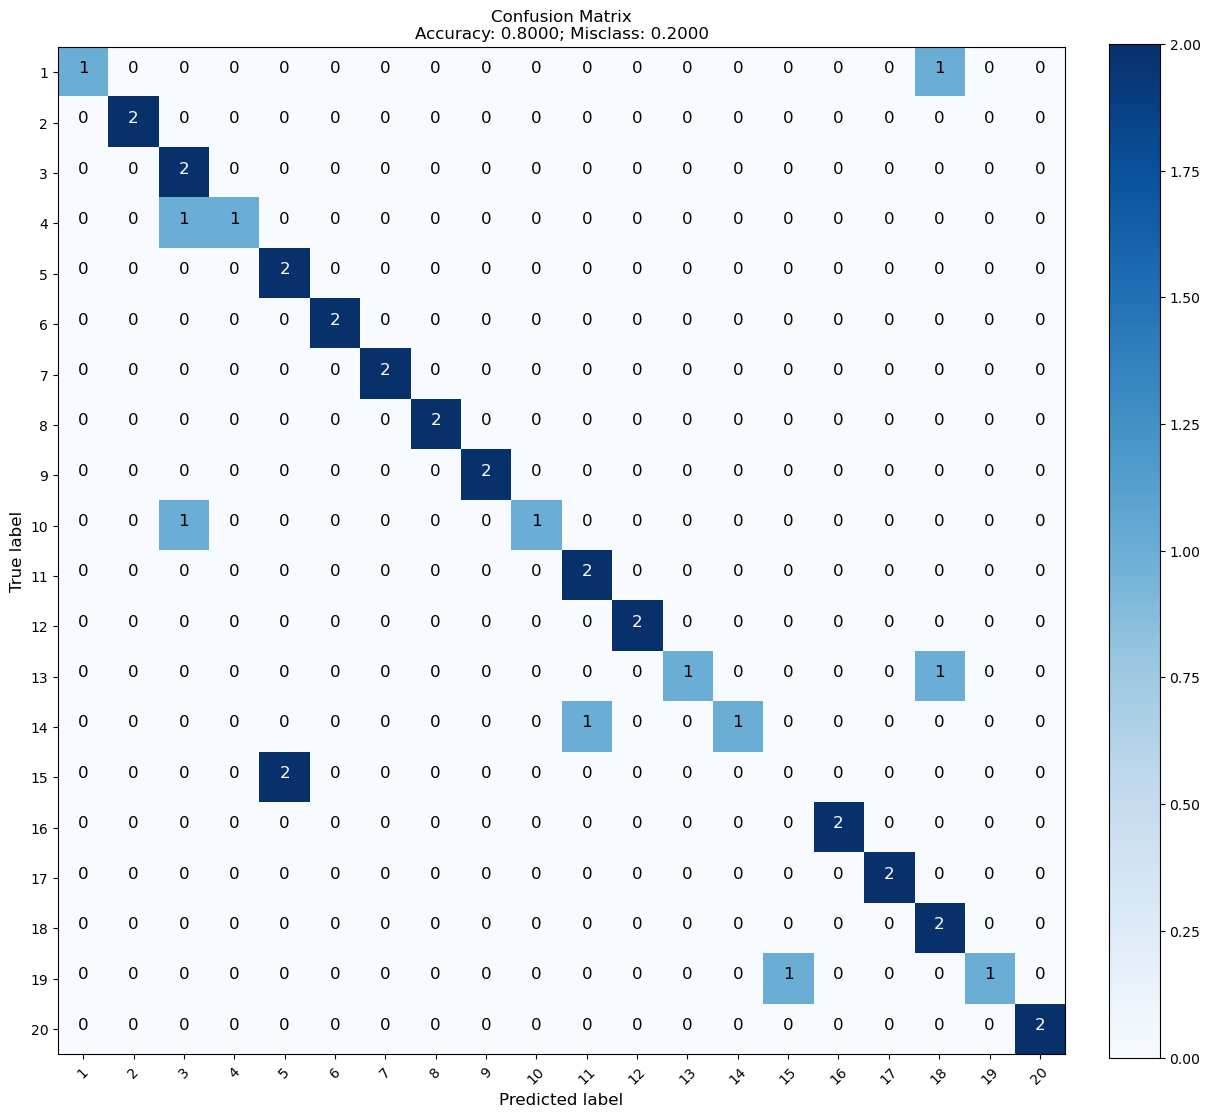

In [167]:
# Using 5 nearest neighbors
knn_neighbors = 11

# n_components: number of principal components
n_components_pca = 100
pca = PCA(n_components=n_components_pca)

# fit the model, e.g., creating the covariance matrix... as we manually did in Lab 4
pca.fit(trainingFaces)

train_pca = pca.transform(trainingFaces)
test_pca = pca.transform(testingFaces)

knn_pca = KNeighborsClassifier(n_neighbors=knn_neighbors).fit(train_pca, trainingLabels)
predictedLabels = knn_pca.predict(test_pca)
# for subjectId in range(1, n_subjects+1):
#     prediction_evaluation(predictedLabels, testingLabels, subjectId)

# Generate the confusion matrix
confusionMatrix = confusion_matrix(testingLabels, predictedLabels)

# accuracies.append( (np.trace(confusionMatrix) / float(np.sum(confusionMatrix))) * 100 )

plot_confusion_matrix(cm=confusionMatrix, target_names = [i for i in range(1, n_subjects+1)])

## Analysis

**As we can see from the results, using 5 nieghbors yeilds significantly better results compared to 11 neighbors. When we used 5 neighbors we got a very high accuracy of 92.5%, and when we increased the number of neighbors to 11, the accuracy dropped significantly to 80%.**

## Conclusion

**Over the course of this lab, we have used a number of different techniques that are used for classifying and identifying faces. First, we created a gallery of images from different subjects. We learned how to create such a gallery and then visualize the images. After that, we learned how to normalize the images and use the normalized images to create a mean image that will be used to extract the eigenfaces. We extracted the eigenfaces and then began probing the system with different images in order to test our our system. We observed that the euclidean distance is a good measure to use. This observation is based on the fact that there was quite a good separation between images that were known to the system and images that were not known to the sytem (there was enough of a gap to allow for a threshold that separtes them successfully). There was also a clear separation betweeen images that are not human faces when compared to images that are. We then used these results regarding the euclidean distances to select a threshold. We decided to take the average of the mean of each probe's euclidean distances and then accunt for the standard deviation in order to capture more authentic images. Finally, we set out to investigate how the number of principal components affects the accuracy. Our results showed us that at 50 principal components, we capture 85% of the accuracy and increasing to 100 and then 200 does not results in any significant change (it went up to 86% with 100 components). We then analyzed the impact of having a different number of neighbors on the accuracy. We observed that 5 neighbors resulted in the best accuracy (92.5%). Finally, we observed that increasing the number of neighbors to 11 significantly decreased the accuracy and took us down to 80%.**
